# Markov Chain Monte Carlo (MCMC)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16}) 
import scipy.stats as stats
import math
import savingfigR as sf

1. Use Metropolis-Hastings sampling to randomly draw numbers from a bivariate normal distribution. The two conditional probabilities are: $p(x|y) = \mathcal{N}(\mu_X + \frac{\sigma_X}{\sigma_Y}\rho(y-\mu_Y), (1 - \rho^2)\sigma_X^2)$ and $p(y|x) = \mathcal{N}(\mu_Y + \frac{\sigma_Y}{\sigma_X}\rho(x-\mu_X), (1-\rho^2)\sigma_Y^2)$. Use the following constants: $\mu_X$ = 78.8, $\sigma_X$ = 3.668, $\mu_Y$ = 211, $\sigma_Y$ = 26.904, and $\rho$ = 0.81 (10 marks).

In [2]:
# parameters
muX = 78.8
sigX = 3.668
muY = 211
sigY = 26.904
rho = 0.81
n=10000
# n = 5

Gibbs (for comparison)

In [3]:
# Gibbs sampler (1: Y, 2: X)
XgY = np.empty(n)
YgX = np.empty(n)
# initialize 
XgY[0] = muX

for i in range(1,n):
    # update 
    x = XgY[i-1]
    # sample 
    YgX[i] = np.random.normal(muY + (sigY/sigX) * rho * (x - muX), np.sqrt((1 - rho**2)*sigY**2))
    # update 
    y = YgX[i]
    # sample
    XgY[i] = np.random.normal(muX + (sigX/sigY) * rho * (y - muY), np.sqrt((1 - rho**2)*sigX**2))

a. Make an algorithm to perform Metropolis-Hastings sampling (5 marks).

In [4]:
def logp(x):
    if x < 0:
        return 0
    else :
        return np.log(x)

In [5]:
# Metropolis-Hastings 
XgYMH = np.empty(n)
YgXMH = np.empty(n)
# initialize 
XgYMH[0] = muX
YgXMH[0] = muY
# iterate 
for i in range(1,n): 
    # 1. Generate random candidate
    xgy = np.random.normal(XgYMH[i-1], 5)
    ygx = np.random.normal(YgXMH[i-1], 30)

    # 2. Calculate acceptance probability 
    num = stats.multivariate_normal.pdf(np.array([xgy, ygx]), np.array([muX, muY]), np.array([[sigX**2, rho*sigX*sigY],[rho*sigX*sigY, sigY**2]]))
    denom = stats.multivariate_normal.pdf(np.array([XgYMH[i-1], YgXMH[i-1]]), np.array([muX, muY]), np.array([[sigX**2, rho*sigX*sigY],[rho*sigX*sigY, sigY**2]]))
    A = np.min([np.log(1), logp(num/denom)])

    # 3. Accept or reject 
    u = np.log(np.random.uniform(low=0, high=1))
    if u <= A: # accept 
        YgXMH[i] = ygx
        XgYMH[i] = xgy    
    else : # reject 
        YgXMH[i] = YgXMH[i-1]
        XgYMH[i] = XgYMH[i-1]

In [6]:
acc_rate = (len(np.unique(YgXMH)) / len(YgXMH)) * 100
print(f'Acceptance rate = {acc_rate:.0f}')

Acceptance rate = 32


b. Plot the marginal distributions of X and Y (3 marks).

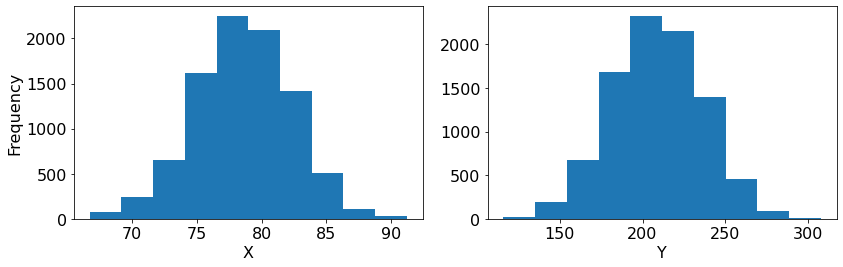

In [7]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(XgYMH[1000:]) # 1000 burn in 
plt.xlabel('X')
plt.ylabel('Frequency')
plt.subplot(1,2,2)
plt.hist(YgXMH[1000:]) #
plt.xlabel('Y')

plt.tight_layout()
plt.show()

sf.best_save(fig, '1bMH')

c. Plot the joint distribution X and Y (2 marks).

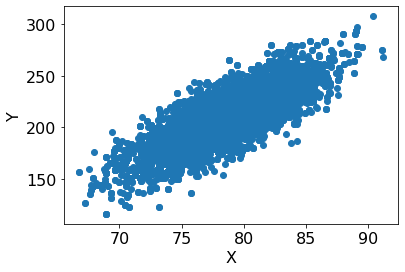

In [8]:
fig = plt.figure()
plt.scatter(XgYMH[1000:], YgXMH[1000:])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

sf.best_save(fig, '1cMH')

Test via numpy sampler 

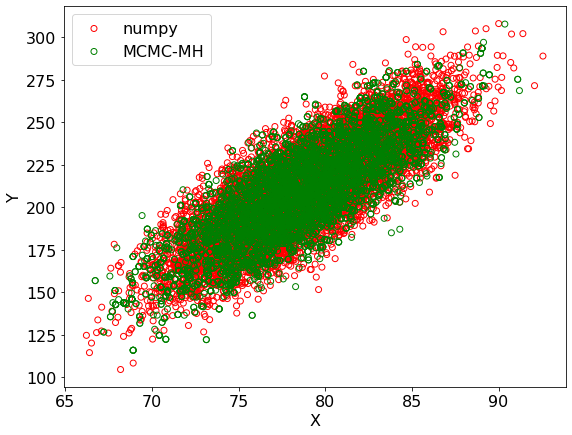

In [9]:
test = np.random.multivariate_normal(np.array([muX, muY]), np.array([[sigX**2, rho*sigX*sigY],[rho*sigX*sigY, sigY**2]]), size=(n,))

fig = plt.figure(figsize=(9,7))
plt.scatter(test[:,0], test[:,1], facecolors='none', edgecolor='r', label='numpy')
plt.scatter(XgYMH[1000:], YgXMH[1000:], facecolors='none', edgecolor='g', label='MCMC-MH')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, '1MHvnp')

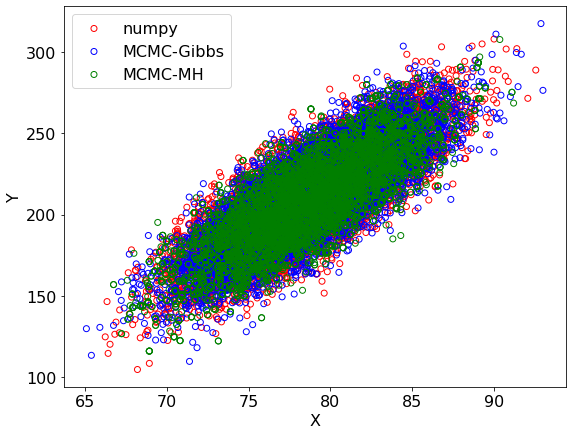

In [10]:
# numpy v gibbs v mh 
fig = plt.figure(figsize=(9,7))
plt.scatter(test[:,0], test[:,1], facecolors='none', edgecolor='r', label='numpy')
plt.scatter(XgY[1000:], YgX[1000:], facecolors='none', edgecolor='b', label='MCMC-Gibbs')
plt.scatter(XgYMH[1000:], YgXMH[1000:], facecolors='none', edgecolor='g', label='MCMC-MH')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'npVGibssVMH')

## Lecture example 

Set up  
---
Prior = Beta($\alpha$=1, $\beta$=1)

Likelihood = Binomial (n=20, k=16)

Posterior = p(w|n,k,$\alpha,\beta$) = $\frac{1}{B(\alpha_h,\beta_h)} w^{\alpha_h - 1}(1-w)^{\beta_h - 1}$, s.t.

$\alpha_h = k + \alpha$

$\beta_h = n - k + \beta$

$p(w|k,n,\alpha,\beta) \propto w^{k+\alpha-1}(1-w^{n-k+\beta-1}) $

Log rules 

$p(w|k,n,\alpha,\beta) \propto (k+\alpha-1)*log(w) + ((n-k+\beta-1)*log(1-w)) $

---

Propose $w$ from $\mathcal{N}(w_t,0.4^2)$

Use the common acceptance function. 

$ A(w',w_t) = \frac{P(w'|k,n,\alpha,\beta)}{P(w_t|k,n,\alpha,\beta)}$

**Don't foget to consider underflow**

In [11]:
# set up 
priorAlpha = 1
priorBeta = 1
likeN = 20
likeK= 16 

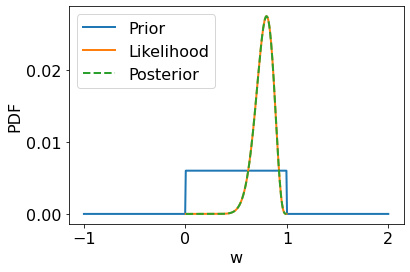

In [12]:
x = np.linspace(-1, 2, num=500)
prior = stats.beta.pdf(x, priorAlpha, priorBeta)
like = stats.binom.pmf(likeK, likeN, x)
prior /= np.nansum(prior)
like /= np.nansum(like)
posterior = prior * like 
posterior /= np.nansum(posterior)

fig = plt.figure()
plt.plot(x, prior, lw=2, label='Prior')
plt.plot(x, like, lw=2, label='Likelihood')
plt.plot(x, posterior, lw=2, ls='--', label='Posterior')
plt.xlabel('w')
plt.ylabel('PDF')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'lMHi')

In [13]:
# Metropolis-Hastings algorithm 

# set up
n = 100000
burn = 1000
w = np.empty(n)
pwgknab = lambda w, k, n, a, b: (k+a-1)*logp(w) + (n-k+b-1)*logp(1-w)

# initialize 
w[0] = 0.5

# iterate 
for i in range(1,n):

    # generate candidate 
    wp = np.random.normal(w[i-1], 0.4)

    # acceptance porbability 
    num = pwgknab(wp, likeK, likeN, priorAlpha, priorBeta)
    denom = pwgknab(w[i-1], likeK, likeN, priorAlpha, priorBeta)
    A = np.min([np.log(1), num-denom])

    # accept or reject 
    u = np.log(np.random.uniform(low=0, high=1))
    if wp > 1 or wp < 0 : # reject (constrain like this?)
        w[i] = w[i-1]
    elif u <= A: # accept 
        w[i] = wp
    else : # reject 
        w[i] = w[i-1]

In [14]:
acc_rate = (len(np.unique(w)) / len(w)) * 100
print(f'Acceptance rate = {acc_rate:.0f}')

Acceptance rate = 26


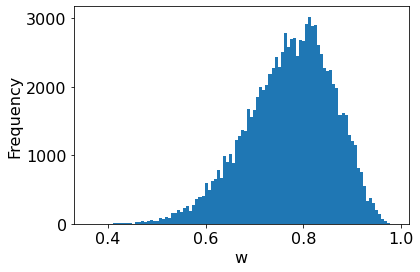

In [15]:
# visualize 
fig = plt.figure()
n, bins, _ = plt.hist(w[burn:], bins=100)
plt.xlabel('w')
plt.ylabel('Frequency')
plt.show()

sf.best_save(fig, 'lMHii')

In [16]:
# posterior for plotting 
xpost = bins[:-1]
ypost = n/sum(n)
print(sum(ypost))

1.0000000000000002


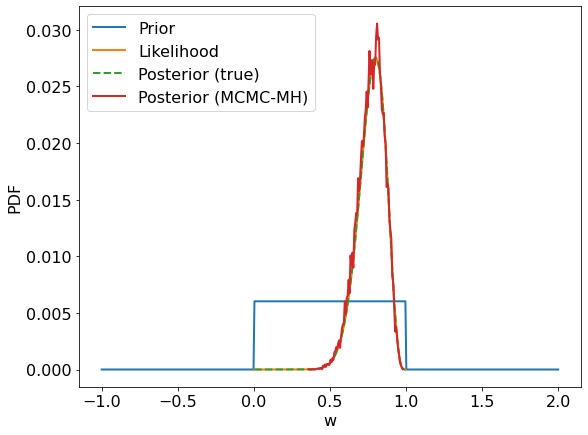

In [17]:
fig = plt.figure(figsize=(9,7))
plt.plot(x, prior, lw=2, label='Prior')
plt.plot(x, like, lw=2, label='Likelihood')
plt.plot(x, posterior, lw=2, ls='--', label='Posterior (true)')
plt.plot(xpost, ypost, lw=2, label='Posterior (MCMC-MH)')
plt.legend(loc='upper left')
plt.xlabel('w')
plt.ylabel('PDF')
plt.show()

sf.best_save(fig, 'lMHiii')

In [18]:
def nll(n, k, p):
    mindiff = -(np.log(math.factorial(n)/(math.factorial(k)*math.factorial(n-k)))+k*np.log(p)+(n-k)*np.log(1-p))
    return mindiff

In [19]:
# visualize parameter space 
n = np.linspace(18,25,8)
k = np.linspace(10,18,9)

NLL = np.empty([len(n),len(k)])
for idx1, N in enumerate(n):
    for idx2, K in enumerate(k): 
        NLL[idx1,idx2] = nll(n=int(N), k=int(K), p=xpost[np.argwhere(ypost == ypost.max())][0][0])

In [20]:
minIdx = np.where(NLL == NLL.min())
print(f'$n$ brute force = {np.round(n[minIdx[0][0]]):.3f}')
print(f'$k$ brute force = {np.round(k[minIdx[1][0]]):.3f}')

$n$ brute force = 18.000
$k$ brute force = 15.000


In [21]:
# optimizer 
# nk = opt.fmin(lambda x: nll(x[0], x[1], p=ypost), np.array((15,19)))
# print(f'$n$ via optimization = {nk[0]:.4f}')
# print(f'$k$ via optimization = {nk[1]:.4f}')

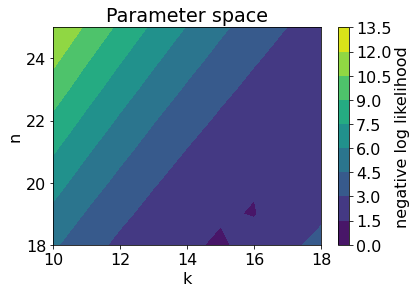

In [22]:
# visualize 
fig = plt.figure()
plt.contourf(k, n, NLL)
plt.colorbar(label='negative log likelihood')
plt.xlabel('k')
plt.ylabel('n')
plt.title('Parameter space')
plt.show()

sf.best_save(fig, 'lMHiv')

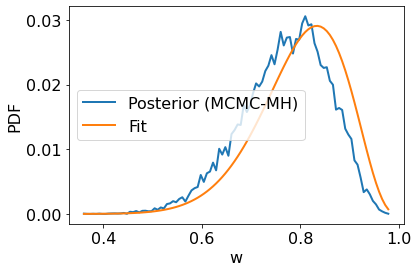

In [23]:
# fit some parameters to the data 
fig = plt.figure()
plt.plot(xpost, ypost, lw=2, label='Posterior (MCMC-MH)')
yfit = stats.binom.pmf(k=np.round(k[minIdx[1][0]]), n=np.round(n[minIdx[0][0]]), p=xpost)
yfit /= np.nansum(yfit)
plt.plot(xpost, yfit, lw=2, label='Fit')
plt.xlabel('w')
plt.ylabel('PDF')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'lMHv')

In [24]:
# bootstrap the max of the samples to get a better estimate of the true p parameter. 
nBoot = 10000
bootmean = np.empty(nBoot)
for i in range(nBoot):
    samp = np.random.choice(w[burn:], len(w[burn:]))
    bootmean[i] = np.mean(samp)

mumu = np.mean(bootmean)

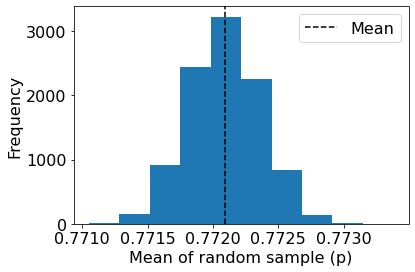

In [25]:
# visualize 
fig = plt.figure()
plt.hist(bootmean)
plt.axvline(mumu, c='k', ls='--', label='Mean')
plt.xlabel('Mean of random sample (p)')
plt.ylabel('Frequency')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'lMHvi')

Try again, but with a more accurate mean (p parameter)

In [26]:
# visualize parameter space 
n = np.linspace(18,25,8)
k = np.linspace(10,18,9)

NLL = np.empty([len(n),len(k)])
for idx1, N in enumerate(n):
    for idx2, K in enumerate(k): 
        NLL[idx1,idx2] = nll(n=int(N), k=int(K), p=mumu)

In [27]:
minIdx = np.where(NLL == NLL.min())
print(f'$n$ brute force = {np.round(n[minIdx[0][0]]):.3f}')
print(f'$k$ brute force = {np.round(k[minIdx[1][0]]):.3f}')

$n$ brute force = 18.000
$k$ brute force = 14.000


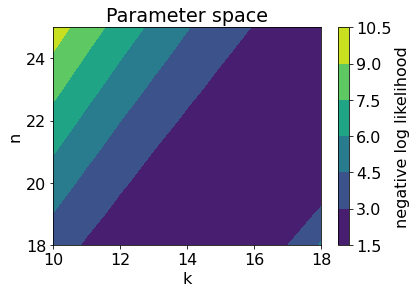

In [28]:
# visualize 
fig = plt.figure()
plt.contourf(k, n, NLL)
plt.colorbar(label='negative log likelihood')
plt.xlabel('k')
plt.ylabel('n')
plt.title('Parameter space')
plt.show()

sf.best_save(fig, 'lMHvii')

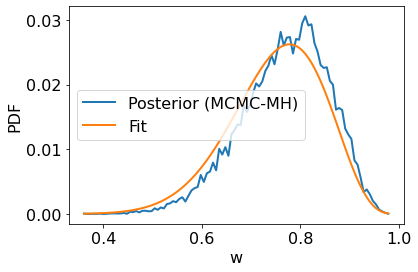

In [29]:
# fit some parameters to the data 
fig = plt.figure()
plt.plot(xpost, ypost, lw=2, label='Posterior (MCMC-MH)')
yfit = stats.binom.pmf(k=np.round(k[minIdx[1][0]]), n=np.round(n[minIdx[0][0]]), p=xpost)
yfit /= np.nansum(yfit)
plt.plot(xpost, yfit, lw=2, label='Fit')
plt.xlabel('w')
plt.ylabel('PDF')
plt.legend(loc=0)
plt.show()

sf.best_save(fig, 'lMHviii')